In [14]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, ".."))

run_results = pd.read_parquet(
    os.path.abspath(
        os.path.join(notebook_dir, "../../cache/parquet/analysis.parquet")
    )
)

print(run_results)

      season  week     gameId gameDisplay           gameDate homeTeamId  \
0       2024     9  401671493  MIA vs BUF  2024-11-03T18:00Z          2   
1       2024     9  401671623  DEN vs BAL  2024-11-03T18:00Z         33   
2       2024     9  401671629  LAC vs CLE  2024-11-03T18:00Z          5   
3       2024     9  401671647  IND vs MIN  2024-11-04T01:20Z         16   
4       2024     9  401671650   NO vs CAR  2024-11-03T18:00Z         29   
...      ...   ...        ...         ...                ...        ...   
1830    2015     3  400791597   SF vs ARI  2015-09-27T20:05Z         22   
1831    2015     3  400791623  BUF vs MIA  2015-09-27T20:25Z         15   
1832    2015     3  400791626  CHI vs SEA  2015-09-27T20:25Z         26   
1833    2015     3  400791631  DEN vs DET  2015-09-28T00:30Z          8   
1834    2015     3  400791635    KC vs GB  2015-09-29T00:30Z          9   

     homeTeamDisplay  homeScore awayTeamId awayTeamDisplay  awayScore  \
0                BUF      

In [15]:
def process_alignment(df: pd.DataFrame):
    res = df[
        ((df["rating"] > 0) & (df["stats"] > 0))
        | ((df["rating"] < 0) & (df["stats"] < 0))
    ]

    align = len(res.index) / len(df.index)

    print("aligned", align)


print("--sanity--")
total = len(run_results.index)

print("total", len(run_results.index))
print("home selected", len(run_results[run_results["grade"] == 2].index) / total)
print("away selected", len(run_results[run_results["grade"] == -2].index) / total)
print("unknown", len(run_results[run_results["grade"] == 0].index) / total)

process_alignment(run_results)

chosen = run_results[(run_results["grade"] == 2) | (run_results["grade"] == -2)]

correct = chosen[
    ((chosen["grade"] == 2) & (chosen["expected"] == True))
    | ((chosen["grade"] == -2) & (chosen["expected"] == False))
]

incorrect = chosen[~chosen.index.isin(correct.index)]

print("accuracy", len(correct.index) / len(chosen.index))

print(
    "rating ->", chosen["rating"].abs().mean(), "stats ->", chosen["stats"].abs().mean()
)
column = incorrect["rating"].abs()
print("rating - incorrect", column.min(), column.mean(), column.max())
column = correct["rating"].abs()
print("rating - correct", column.min(), column.mean(), column.max())

column = incorrect["stats"].abs()
print("stats - incorrect", column.min(), column.mean(), column.max())
column = correct["stats"].abs()
print("stats - correct", column.min(), column.mean(), column.max())

--sanity--
total 1835
home selected 0.4250681198910082
away selected 0.46376021798365125
unknown 0.1111716621253406
aligned 0.8888283378746594
accuracy 0.5855303494788473
rating -> 138.38466298092226 stats -> 148.8591044621592
rating - incorrect 0.7337285009695051 130.97054509677392 686.1467609361325
rating - correct 0.1977689584165887 143.63277155650786 716.9392455017621
stats - incorrect 0.017780270880962235 146.97129750676692 2508.5119207948337
stats - correct 0.014602658117041756 150.19539504000753 1688.9980089543183


In [16]:
sub_select = chosen[(abs(chosen["stats"]) > 95) & (abs(chosen["rating"]) > 85)]

sub_correct = sub_select[
    ((sub_select["grade"] == 2) & (sub_select["expected"] == True))
    | ((sub_select["grade"] == -2) & (sub_select["expected"] == False))
]

print("available", total)
print("correct", len(sub_correct.index), "chosen", len(sub_select.index))
print("accuracy", len(sub_correct.index) / len(sub_select.index))

available 1835
correct 534 chosen 856
accuracy 0.6238317757009346


In [ ]:
import numpy as np
import seaborn as sbn

from scipy import stats

reduced = run_results[(np.abs(stats.zscore(run_results[['stats', 'rating']])) < 3).all(axis=1)].copy()

reduced['merge'] = reduced['stats'] + reduced['rating']
reduced['diff'] = reduced['homeScore'] - reduced['awayScore']


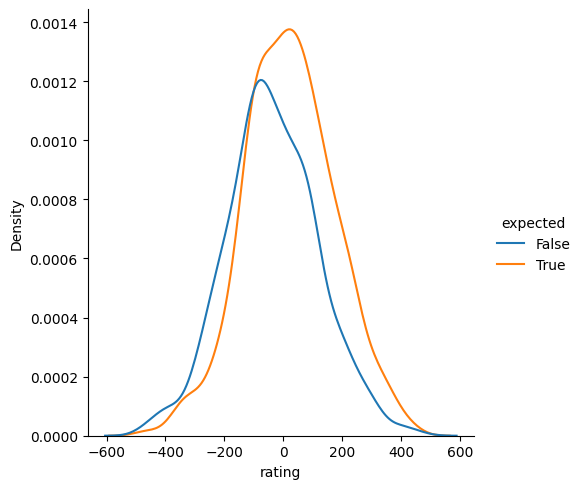

In [ ]:
sbn.displot(data=reduced, x="rating", hue='expected', kind="kde")

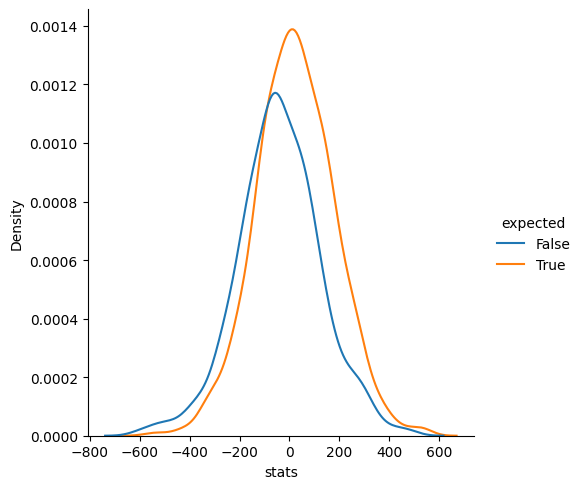

In [ ]:
sbn.displot(data=reduced, x="stats", hue='expected', kind="kde")

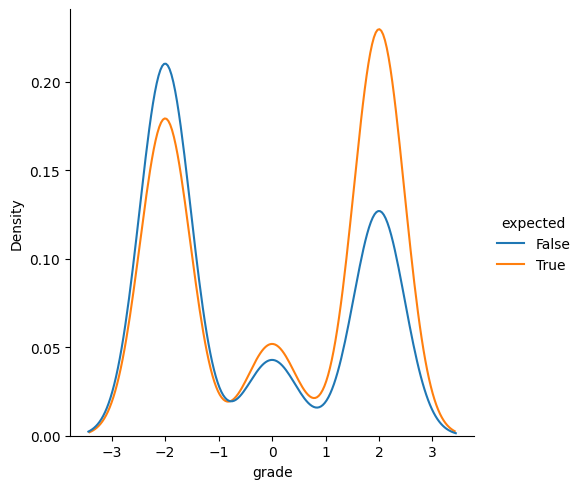

In [ ]:
sbn.displot(data=reduced, x="grade", hue='expected', kind="kde")

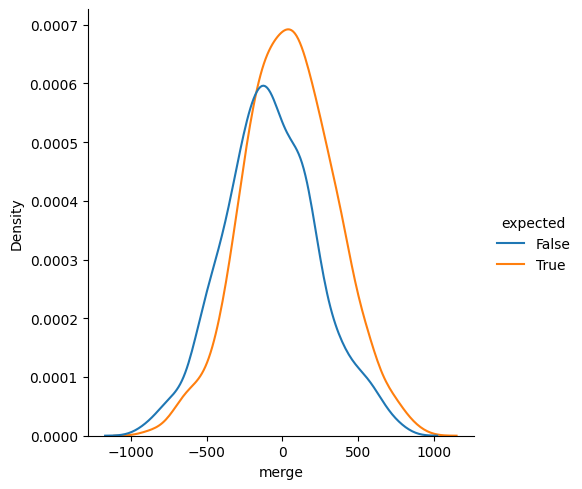

In [ ]:
sbn.displot(data=reduced, x="merge", hue='expected', kind="kde")

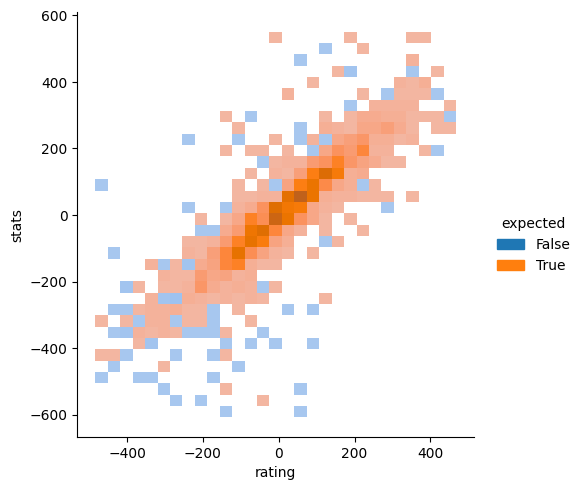

In [ ]:
sbn.displot(data=reduced, x="rating", y="stats", hue='expected')

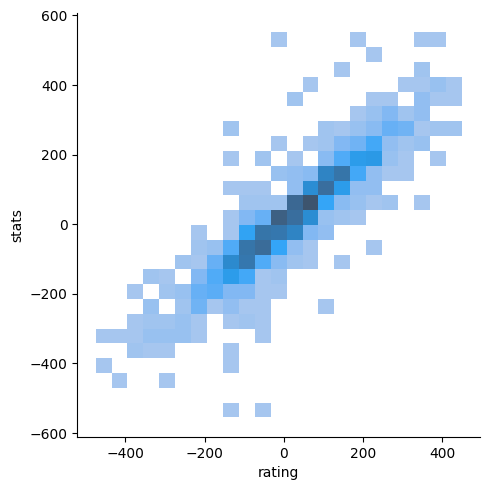

In [ ]:
sbn.displot(data=reduced[reduced['expected'] == True], x="rating", y="stats")

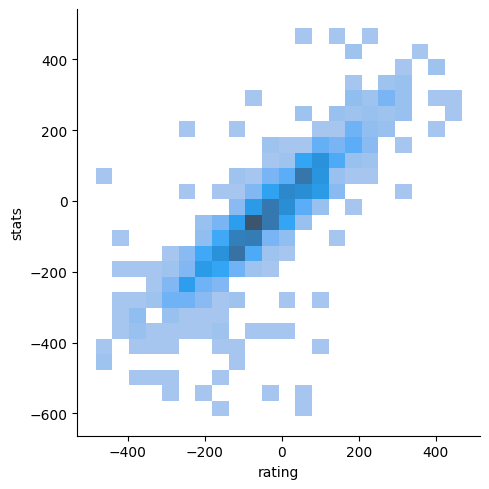

In [ ]:
sbn.displot(data=reduced[reduced['expected'] == False], x="rating", y="stats")

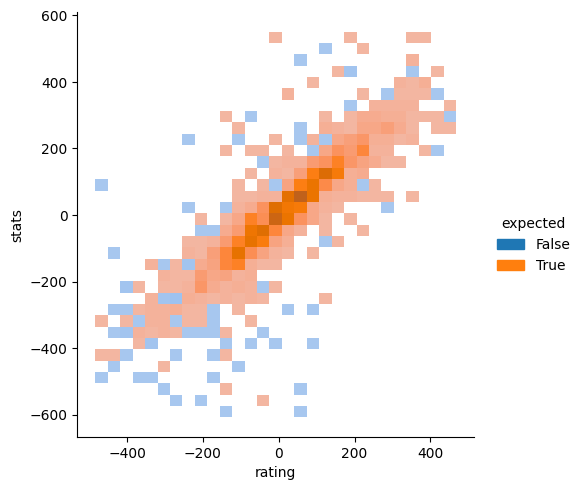

In [ ]:
sbn.displot(data=reduced, x="rating", y="stats", hue='expected')

In [ ]:
sbn.displot(data=reduced, x="stats", y="diff", hue='expected')

In [29]:
from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation 
def show_correlation(column: str, compare: str):
    print(f"Show correlation of: {column} vs {compare}")

    pearson_corr, _ = pearsonr(reduced[column], reduced[compare])
    print(f"Pearson correlation: {pearson_corr}")

    # Calculate Spearman correlation 
    spearman_corr, _ = spearmanr(reduced[column], reduced[compare])
    print(f"Spearman correlation: {spearman_corr}")

show_correlation('stats', 'expected')
show_correlation('rating', 'expected')
show_correlation('merge', 'expected')
show_correlation('diff', 'expected')
show_correlation('stats', 'diff')
show_correlation('rating', 'diff')
show_correlation('merge', 'diff')

Show correlation of: stats vs expected
Pearson correlation: 0.19716026571267592
Spearman correlation: 0.1985404361273197
Show correlation of: rating vs expected
Pearson correlation: 0.18922324290610948
Spearman correlation: 0.19079324957552887
Show correlation of: merge vs expected
Pearson correlation: 0.2001606146827438
Spearman correlation: 0.20171041303378862
Show correlation of: diff vs expected
Pearson correlation: 0.7791513528652828
Spearman correlation: 0.8632236337330773
Show correlation of: stats vs diff
Pearson correlation: 0.24979421329476548
Spearman correlation: 0.2576285536658958
Show correlation of: rating vs diff
Pearson correlation: 0.26162509453979976
Spearman correlation: 0.2586706330195192
Show correlation of: merge vs diff
Pearson correlation: 0.26461413387254346
Spearman correlation: 0.2655963700883921
